# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups  
Sample_088  H0YLF3             17.407
Sample_188  P20827             17.714
Sample_017  Q12797;Q12797-10   12.906
Sample_092  P61278             19.174
Sample_126  P21579             15.158
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_055  D6RFM1;P20396    14.867
Sample_035  O95998           17.982
Sample_087  H0Y7C8;O14657    10.585
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.052
            A0A075B6Q5                 13.014
            A0A075B6R2                 12.672
            A0A075B6S5                 12.017
            A0A087WSY4                 12.296
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.961
            Q9UI40;Q9UI40-2            11.661
            Q9UIW2                     13.737
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.554
            Q9UP79                     13.559
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.289,15.050,16.842,19.863,16.268,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.679,19.067,...,15.528,15.576,14.241,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.225,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.083,17.705,17.039,15.820,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.403,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.088,15.345,17.084,18.708,14.249,19.433,12.187,11.374
Sample_207,15.739,16.877,15.469,16.898,14.858,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.116,15.425,12.067,13.153,14.623,12.772,11.870,14.694,11.587,12.326
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.935,19.067,16.127,...,12.401,13.134,13.497,12.986,13.289,13.376,12.795,12.728,12.993,13.400
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.586,12.419,12.997,12.570,13.099,12.824,12.943,12.691,11.543,12.050
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.629,12.578,13.676,13.049,12.384,12.814,13.881,12.764,11.992,11.932
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.035,13.720,13.166,12.357,12.870,13.057,12.300,12.210,13.159,12.664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.783,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 393.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.64it/s]

100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.54it/s]

100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.38it/s]

100%|██████████| 4/4 [00:00<00:00,  5.65it/s]

100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.67it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.33it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.75it/s]

100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.85it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.01it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.54it/s]

100%|██████████| 6/6 [00:01<00:00,  4.35it/s]

100%|██████████| 6/6 [00:01<00:00,  4.69it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.52it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.25it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.68it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.34it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.10it/s]

100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.20it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.98it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.81it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.37it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.25it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.04it/s]

100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.60it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.49it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.66it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.31it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.03it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.08it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.16it/s]

100%|██████████| 9/9 [00:02<00:00,  4.20it/s]

100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.63it/s]

 30%|███       | 3/10 [00:00<00:01,  5.22it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.11it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.73it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.80it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.72it/s]

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.63it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.00it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.26it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.18it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.21it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.10it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.97it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

100%|██████████| 11/11 [00:02<00:00,  4.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.42it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.76it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.23it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.13it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.11it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.25it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.18it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.86it/s]

100%|██████████| 12/12 [00:02<00:00,  4.02it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.24it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.44it/s]

 31%|███       | 4/13 [00:00<00:02,  4.09it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.66it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.44it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.10it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.04it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.96it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.90it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.94it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.06it/s]

100%|██████████| 13/13 [00:03<00:00,  3.04it/s]

100%|██████████| 13/13 [00:03<00:00,  3.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.29it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.37it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.13it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.19it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.45it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.44it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.35it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.46it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.53it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.61it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.29it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.35it/s]

100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

100%|██████████| 14/14 [00:04<00:00,  3.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.35it/s]

 20%|██        | 3/15 [00:00<00:02,  4.74it/s]

 27%|██▋       | 4/15 [00:00<00:03,  3.51it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.28it/s]

 40%|████      | 6/15 [00:01<00:03,  2.98it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.69it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.75it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.82it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.04it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.15it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.06it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.18it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.24it/s]

100%|██████████| 15/15 [00:04<00:00,  3.46it/s]

100%|██████████| 15/15 [00:04<00:00,  3.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.039 0.017          0.904 0.150       0.173   
2             0.004 0.003      0.042 0.016          0.758 0.091       0.627   
3             0.003 0.001      0.039 0.012          0.746 0.099       0.636   
4             0.004 0.003      0.038 0.012          0.779 0.084       0.740   
5             0.004 0.004      0.039 0.011          0.789 0.089       0.774   
6             0.003 0.001      0.037 0.009          0.782 0.089       0.765   
7             0.003 0.000      0.035 0.003          0.780 0.090       0.759   
8             0.003 0.000      0.037 0.008          0.795 0.078       0.806   
9             0.003 0.000      0.035 0.005          0.775 0.076       0.788   
10            0.004 0.003      0.035 0.005          0.774 0.082       0.791   
11            0.003 0.000      0.031 0.002          0.809 0.081       0.847   
12            0.003 0.000      0.032 0.003          0.814 0.083       0.846   
13            0.005 0.004      0.047 0.021          0.809 0.084       0.847   
14            0.005 0.004      0.043 0.015          0.822 0.083       0.848   
15            0.005 0.004      0.049 0.018          0.818 0.085       0.825   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.093   0.280 0.126                  0.578 0.045        0.855   
2          0.104   0.681 0.080                  0.739 0.058        0.802   
3          0.108   0.680 0.079                  0.736 0.058        0.796   
4          0.106   0.755 0.080                  0.793 0.064        0.864   
5          0.113   0.778 0.087                  0.811 0.072        0.872   
6          0.116   0.769 0.087                  0.804 0.071        0.870   
7          0.119   0.765 0.090                  0.800 0.073        0.867   
8          0.115   0.796 0.081                  0.826 0.069        0.890   
9          0.113   0.776 0.071                  0.809 0.060        0.889   
10         0.110   0.777 0.073                  0.810 0.062        0.890   
11         0.085   0.824 0.065                  0.849 0.057        0.912   
12         0.090   0.826 0.069                  0.851 0.060        0.911   
13         0.093   0.824 0.068                  0.849 0.059        0.909   
14         0.092   0.831 0.068                  0.855 0.059        0.911   
15         0.098   0.817 0.069                  0.844 0.059        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.825 0.088        210.000 0.000  
2          0.066                  0.778 0.086        210.000 0.000  
3          0.071                  0.773 0.088        210.000 0.000  
4          0.060                  0.850 0.068        210.000 0.000  
5          0.065                  0.867 0.067        210.000 0.000  
6          0.065                  0.863 0.068        210.000 0.000  
7          0.065                  0.860 0.068        210.000 0.000  
8          0.054                  0.875 0.057        210.000 0.000  
9          0.054                  0.873 0.058        210.000 0.000  
10         0.054                  0.876 0.056        210.000 0.000  
11         0.049                  0.905 0.050        210.000 0.000  
12         0.050                  0.904 0.050        210.000 0.000  
13         0.051                  0.902 0.051        210.000 0.000  
14         0.050                  0.900 0.052        210.000 0.000  
15         0.047                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 527.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.52it/s]

100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.11it/s]

100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.12it/s]

100%|██████████| 4/4 [00:00<00:00,  3.93it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.20it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.23it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.27it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.74it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.57it/s]

100%|██████████| 6/6 [00:02<00:00,  2.48it/s]

100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.41it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.83it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.17it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.15it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.62it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.72it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.13it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.67it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.42it/s]

100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.78it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.97it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.26it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.90it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.65it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.55it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.61it/s]

 30%|███       | 3/10 [00:00<00:01,  4.08it/s]

 40%|████      | 4/10 [00:01<00:01,  3.62it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.70it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.52it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.41it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.41it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.30it/s]

100%|██████████| 10/10 [00:02<00:00,  3.25it/s]

100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.58it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.09it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.40it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.09it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.06it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.17it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.15it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.14it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.20it/s]

100%|██████████| 11/11 [00:03<00:00,  3.26it/s]

100%|██████████| 11/11 [00:03<00:00,  3.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.30it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.84it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.58it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.93it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.85it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.86it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.79it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.85it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.90it/s]

100%|██████████| 12/12 [00:03<00:00,  2.99it/s]

100%|██████████| 12/12 [00:03<00:00,  3.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.54it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.05it/s]

 31%|███       | 4/13 [00:00<00:02,  3.81it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.75it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.67it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.54it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.27it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.95it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.74it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.39it/s]

100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.43it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.12it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.73it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.61it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.69it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.97it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.13it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.19it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.24it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.17it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.21it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.15it/s]

100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.50it/s]

 20%|██        | 3/15 [00:00<00:03,  3.69it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.84it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.43it/s]

 40%|████      | 6/15 [00:02<00:03,  2.30it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.16it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.18it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.36it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.54it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.70it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.88it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  3.07it/s]

100%|██████████| 15/15 [00:05<00:00,  3.19it/s]

100%|██████████| 15/15 [00:05<00:00,  2.73it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.050 0.020          0.023 0.117       0.004   
2             0.004 0.003      0.043 0.019          0.630 0.334       0.168   
3             0.003 0.002      0.036 0.007          0.682 0.087       0.564   
4             0.003 0.002      0.038 0.010          0.673 0.098       0.566   
5             0.004 0.002      0.038 0.010          0.745 0.094       0.709   
6             0.003 0.002      0.045 0.014          0.743 0.100       0.712   
7             0.004 0.003      0.044 0.018          0.765 0.087       0.750   
8             0.005 0.003      0.046 0.016          0.775 0.091       0.756   
9             0.004 0.002      0.043 0.016          0.770 0.092       0.757   
10            0.005 0.004      0.047 0.016          0.796 0.094       0.781   
11            0.004 0.003      0.043 0.015          0.790 0.087       0.778   
12            0.005 0.004      0.046 0.017          0.786 0.091       0.792   
13            0.004 0.002      0.036 0.006          0.792 0.092       0.788   
14            0.006 0.005      0.052 0.022          0.819 0.086       0.797   
15            0.004 0.003      0.042 0.013          0.821 0.090       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.018   0.006 0.032                  0.498 0.010        0.861   
2          0.115   0.251 0.154                  0.553 0.055        0.721   
3          0.122   0.610 0.093                  0.685 0.065        0.758   
4          0.123   0.607 0.096                  0.681 0.068        0.753   
5          0.108   0.722 0.079                  0.764 0.064        0.832   
6          0.111   0.721 0.081                  0.764 0.065        0.827   
7          0.104   0.752 0.071                  0.789 0.058        0.895   
8          0.104   0.760 0.069                  0.795 0.057        0.896   
9          0.108   0.758 0.074                  0.793 0.061        0.893   
10         0.093   0.783 0.067                  0.814 0.056        0.910   
11         0.098   0.779 0.070                  0.811 0.058        0.909   
12         0.106   0.783 0.071                  0.815 0.059        0.913   
13         0.103   0.784 0.071                  0.816 0.059        0.914   
14         0.105   0.803 0.077                  0.833 0.064        0.920   
15         0.104   0.804 0.078                  0.833 0.065        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.829 0.087        210.000 0.000  
2          0.122                  0.682 0.134        210.000 0.000  
3          0.062                  0.685 0.085        210.000 0.000  
4          0.063                  0.681 0.089        210.000 0.000  
5          0.056                  0.793 0.077        210.000 0.000  
6          0.058                  0.790 0.079        210.000 0.000  
7          0.049                  0.870 0.060        210.000 0.000  
8          0.050                  0.872 0.061        210.000 0.000  
9          0.051                  0.870 0.062        210.000 0.000  
10         0.048                  0.888 0.056        210.000 0.000  
11         0.046                  0.887 0.058        210.000 0.000  
12         0.046                  0.888 0.057        210.000 0.000  
13         0.044                  0.890 0.054        210.000 0.000  
14         0.042                  0.896 0.054        210.000 0.000  
15         0.042                  0.896 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1239.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 34.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.76it/s]

100%|██████████| 3/3 [00:00<00:00, 19.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 25.40it/s]

100%|██████████| 4/4 [00:00<00:00, 22.63it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 28.08it/s]

100%|██████████| 5/5 [00:00<00:00, 20.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.29it/s]

100%|██████████| 6/6 [00:00<00:00, 18.78it/s]

100%|██████████| 6/6 [00:00<00:00, 18.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.15it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.42it/s]

100%|██████████| 7/7 [00:00<00:00, 15.03it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.71it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 19.40it/s]

100%|██████████| 8/8 [00:00<00:00, 17.34it/s]

100%|██████████| 8/8 [00:00<00:00, 18.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 13.80it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 13.28it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.23it/s]

100%|██████████| 9/9 [00:00<00:00, 13.45it/s]

100%|██████████| 9/9 [00:00<00:00, 13.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 23.77it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.78it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.28it/s]

100%|██████████| 10/10 [00:00<00:00, 16.53it/s]

100%|██████████| 10/10 [00:00<00:00, 16.97it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.66it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 12.84it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.13it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.56it/s]

100%|██████████| 11/11 [00:00<00:00, 13.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.08it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.51it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.96it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.64it/s]

100%|██████████| 12/12 [00:00<00:00, 15.06it/s]

100%|██████████| 12/12 [00:00<00:00, 16.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.13it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.86it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.96it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.17it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.94it/s]

100%|██████████| 13/13 [00:00<00:00, 14.89it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.38it/s]

 43%|████▎     | 6/14 [00:00<00:00, 18.85it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.76it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.78it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.29it/s]

100%|██████████| 14/14 [00:00<00:00, 14.51it/s]

100%|██████████| 14/14 [00:00<00:00, 15.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.11it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.43it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.03it/s]

 60%|██████    | 9/15 [00:00<00:00, 14.11it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.26it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 14.46it/s]

100%|██████████| 15/15 [00:01<00:00, 13.80it/s]

100%|██████████| 15/15 [00:01<00:00, 13.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.048 0.017          0.000 0.000       0.000   
2             0.004 0.003      0.048 0.019          0.623 0.103       0.375   
3             0.003 0.000      0.037 0.009          0.675 0.088       0.568   
4             0.006 0.008      0.050 0.023          0.738 0.083       0.643   
5             0.004 0.002      0.038 0.013          0.701 0.089       0.618   
6             0.006 0.006      0.060 0.026          0.688 0.079       0.642   
7             0.005 0.005      0.053 0.023          0.704 0.099       0.627   
8             0.005 0.005      0.062 0.028          0.701 0.096       0.636   
9             0.005 0.004      0.046 0.019          0.720 0.096       0.634   
10            0.007 0.007      0.056 0.022          0.713 0.093       0.626   
11            0.003 0.001      0.042 0.018          0.707 0.096       0.625   
12            0.006 0.006      0.065 0.024          0.708 0.100       0.657   
13            0.005 0.004      0.055 0.022          0.711 0.101       0.658   
14            0.006 0.005      0.061 0.020          0.702 0.098       0.649   
15            0.004 0.003      0.041 0.015          0.704 0.093       0.665   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.069   0.463 0.064                  0.601 0.042        0.664   
3          0.095   0.613 0.079                  0.683 0.059        0.749   
4          0.109   0.683 0.084                  0.738 0.063        0.772   
5          0.117   0.651 0.094                  0.713 0.067        0.779   
6          0.107   0.660 0.082                  0.715 0.063        0.781   
7          0.111   0.657 0.088                  0.715 0.066        0.813   
8          0.120   0.661 0.094                  0.718 0.071        0.812   
9          0.110   0.668 0.087                  0.725 0.065        0.823   
10         0.111   0.660 0.082                  0.718 0.061        0.821   
11         0.108   0.657 0.083                  0.715 0.063        0.816   
12         0.117   0.676 0.095                  0.728 0.072        0.829   
13         0.105   0.678 0.085                  0.729 0.067        0.831   
14         0.113   0.669 0.088                  0.722 0.066        0.826   
15         0.116   0.678 0.089                  0.729 0.069        0.831   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.681 0.085        210.000 0.000  
2          0.063                  0.608 0.073        210.000 0.000  
3          0.058                  0.698 0.071        210.000 0.000  
4          0.062                  0.721 0.081        210.000 0.000  
5          0.065                  0.729 0.084        210.000 0.000  
6          0.063                  0.742 0.078        210.000 0.000  
7          0.066                  0.773 0.076        210.000 0.000  
8          0.067                  0.774 0.076        210.000 0.000  
9          0.064                  0.787 0.075        210.000 0.000  
10         0.061                  0.782 0.071        210.000 0.000  
11         0.063                  0.775 0.074        210.000 0.000  
12         0.059                  0.779 0.075        210.000 0.000  
13         0.059                  0.782 0.073        210.000 0.000  
14         0.057                  0.775 0.074        210.000 0.000  
15         0.055                  0.779 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,10
score_time,15,14,12
test_precision,1,15,4
test_recall,14,14,15
test_f1,14,15,4
test_balanced_accuracy,14,15,4
test_roc_auc,11,14,13
test_average_precision,11,14,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.09it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.21it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.69it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.83it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.56it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.52it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.54it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.41it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.53it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.73it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.74it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.69it/s]

100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.64it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.22it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.91it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.87it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.77it/s]

100%|██████████| 13/13 [00:00<00:00, 13.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.90it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.90it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.23it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.49it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.31it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.23it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.33it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.53it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.76it/s]

100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


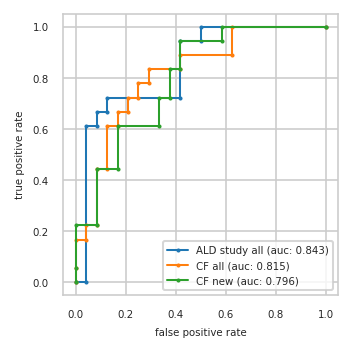

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.611  0.000 0.167  0.000 0.222
3          0.083 0.611  0.042 0.167  0.083 0.222
4          0.083 0.667  0.042 0.222  0.083 0.444
5          0.125 0.667  0.083 0.222  0.167 0.444
6          0.125 0.722  0.083 0.444  0.167 0.611
7          0.417 0.722  0.125 0.444  0.333 0.611
8          0.417 0.944  0.125 0.611  0.333 0.722
9          0.500 0.944  0.167 0.611  0.375 0.722
10         0.500 1.000  0.167 0.667  0.375 0.833
11         1.000 1.000  0.208 0.667  0.417 0.833
12           NaN   NaN  0.208 0.722  0.417 0.944
13           NaN   NaN  0.250 0.722  0.583 0.944
14           NaN   NaN  0.250 0.778  0.583 1.000
15           NaN   NaN  0.292 0.778  1.000 1.000
16           NaN   NaN  0.292 0.833    NaN   NaN
17           NaN   NaN  0.417 0.833    NaN   NaN
18           NaN   NaN  0.417 0.889    NaN   NaN
19           NaN   NaN  0.625 0.889    NaN   NaN
20           NaN   NaN  0.625 1.000    NaN   NaN
21           NaN   NaN  1.000 1.000    NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,Q01995,Q16799
2,H7BY64;Q96NZ9;Q96NZ9-4,F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5,P51688
3,P61981,P02741,P31321
4,P14174,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
5,P04075,P04075,Q96GD0
6,Q99983,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,Q9Y2T3;Q9Y2T3-3,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P05413;S4R371,Q14894,P05556;P05556-2;P05556-3;P05556-4;P05556-5


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


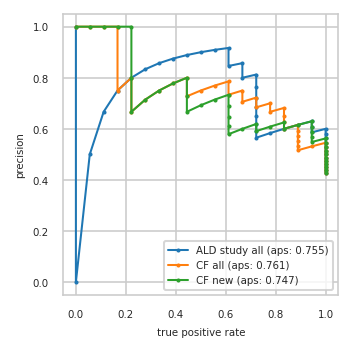

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.531 0.944     0.562 1.000
11         0.581 1.000     0.516 0.889     0.548 0.944
12         0.600 1.000     0.533 0.889     0.567 0.944
13         0.586 0.944     0.552 0.889     0.586 0.944
14         0.607 0.944     0.571 0.889     0.607 0.944
15         0.630 0.944     0.593 0.889     0.630 0.944
16         0.615 0.889     0.615 0.889     0.615 0.889
17         0.600 0.833     0.600 0.833     0.600 0.833
18         0.583 0.778     0.625 0.833     0.625 0.833
19         0.565 0.722     0.652 0.833     0.609 0.778
20         0.591 0.722     0.682 0.833     0.591 0.722
21         0.619 0.722     0.667 0.778     0.619 0.722
22         0.650 0.722     0.700 0.778     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.765 0.722     0.706 0.667     0.647 0.611
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.800 0.667     0.733 0.611     0.733 0.611
28         0.857 0.667     0.786 0.611     0.714 0.556
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.917 0.611     0.750 0.500     0.667 0.444
31         0.909 0.556     0.727 0.444     0.727 0.444
32         0.900 0.500     0.800 0.444     0.800 0.444
33         0.889 0.444     0.778 0.389     0.778 0.389
34         0.875 0.389     0.750 0.333     0.750 0.333
35         0.857 0.333     0.714 0.278     0.714 0.278
36         0.833 0.278     0.667 0.222     0.667 0.222
37         0.800 0.222     0.800 0.222     0.800 0.222
38         0.750 0.167     0.750 0.167     1.000 0.222
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


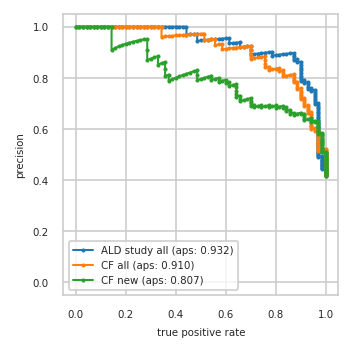

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


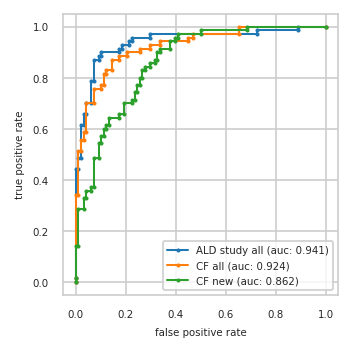

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}